## M1. Tarea - Diploma Fundamentos Análisis Datos Fútbol

### Justificación Metodológica: Sistema Propio vs Tableau

Para este análisis he optado por desarrollar visualizaciones propias en Python en lugar de utilizar Tableau por dos razones principales.

**Limitación de acceso:** Ya utilicé la licencia gratuita de Tableau for Students durante mis estudios universitarios, y estas licencias tienen restricciones de reutilización. Acceder nuevamente requeriría una suscripción comercial que no es viable para uso académico individual.

**Ventaja técnica:** Mi formación en Business Analytics e Inteligencia Artificial me permite desarrollar un sistema de extracción y visualización más especializado. He creado extractores propios que se conectan directamente a las APIs de UnderStat, FBRef y WhoScored, obteniendo datos en tiempo real y aplicando transformaciones específicas para análisis de fútbol. Esto me da control total sobre el pipeline de datos y permite crear visualizaciones especializadas (como shot maps con campos realistas y bullet charts académicos) que van más allá de los templates estándar de Tableau.

El resultado es un sistema completamente automatizado, reproducible y optimizado específicamente para análisis deportivo avanzado, que además me permite integrar múltiples fuentes de datos de manera más eficiente que las herramientas comerciales estándar.

In [10]:
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

from visualization.match_data import extract_complete_match

In [11]:
print("Loading match data...")
match_data = extract_complete_match(
    whoscored_id=1821720,
    understat_id=27324,  # Necesitas el ID de Understat también
    league="ESP-La Liga",
    season="2024-25",
    verbose=True
)

Loading match data...
Extracting complete match data (ESP-La Liga 2024-25)
   WhoScored ID: 1821720
   Understat ID: 27324
Processing match 1821720 (ESP-La Liga 2024-25) - Source: whoscored
   Data found, loading from cache...
Processing match 27324 (ESP-La Liga 2024-25) - Source: understat
   Data found, loading from cache...
   Combined data types: passes, players, connections, shots


In [15]:
"""
Mini Análisis: Datos de Disparos por Jugador
Barcelona 4-3 Real Madrid - Match ID: 27324
"""

import pandas as pd
import numpy as np

def load_and_explore_data():
    """Carga y explora datos básicos del partido"""
    df = pd.read_csv('data/match_understat_27324_shots.csv')
    
    # Mapeo de equipos
    df['team_name'] = df['team_id'].map({148: 'Barcelona', 150: 'Real Madrid'})
    
    print("DATOS BÁSICOS DEL PARTIDO")
    print("=" * 40)
    print(f"Total de disparos: {len(df)}")
    print(f"Barcelona: {len(df[df['team_name'] == 'Barcelona'])} disparos")
    print(f"Real Madrid: {len(df[df['team_name'] == 'Real Madrid'])} disparos")
    print(f"Total de goles: {df['is_goal'].sum()}")
    
    return df

def analyze_players(df):
    """Análisis por jugadores individuales"""
    
    print("\n" + "="*50)
    print("ANÁLISIS POR JUGADORES")
    print("="*50)
    
    # Estadísticas por jugador (usando player_id)
    player_stats = df.groupby(['team_name', 'player_id']).agg({
        'shot_xg': ['count', 'sum', 'mean'],
        'is_goal': 'sum',
        'shot_distance_to_goal': 'mean'
    }).round(3)
    
    player_stats.columns = ['Disparos', 'xG_Total', 'xG_Promedio', 'Goles', 'Distancia_Promedio']
    player_stats['Eficiencia'] = (player_stats['Goles'] / player_stats['xG_Total']).round(2)
    
    # Filtrar jugadores con más de 1 disparo
    player_stats_filtered = player_stats[player_stats['Disparos'] > 1].sort_values('xG_Total', ascending=False)
    
    print("\nJUGADORES CON MÁS DE 1 DISPARO:")
    print(player_stats_filtered)
    
    print("\nTOP 5 JUGADORES POR xG TOTAL:")
    top_xg = player_stats.sort_values('xG_Total', ascending=False).head()
    print(top_xg[['Disparos', 'xG_Total', 'Goles', 'Eficiencia']])
    
    print("\nJUGADORES QUE MARCARON:")
    scorers = player_stats[player_stats['Goles'] > 0].sort_values('Goles', ascending=False)
    print(scorers[['Disparos', 'xG_Total', 'Goles', 'Eficiencia']])
    
    return player_stats

def analyze_shot_situations(df):
    """Análisis por situaciones de disparo"""
    
    print("\n" + "="*50)
    print("ANÁLISIS POR SITUACIONES")
    print("="*50)
    
    # Por situación de juego
    situation_stats = df.groupby(['team_name', 'shot_situation']).agg({
        'shot_xg': ['count', 'sum', 'mean'],
        'is_goal': 'sum'
    }).round(3)
    
    situation_stats.columns = ['Disparos', 'xG_Total', 'xG_Promedio', 'Goles']
    
    print("\nPOR SITUACIÓN DE JUEGO:")
    print(situation_stats)
    
    # Por parte del cuerpo
    if 'shot_body_part' in df.columns:
        body_stats = df.groupby(['team_name', 'shot_body_part']).agg({
            'shot_xg': ['count', 'sum', 'mean'],
            'is_goal': 'sum'
        }).round(3)
        
        body_stats.columns = ['Disparos', 'xG_Total', 'xG_Promedio', 'Goles']
        
        print("\nPOR PARTE DEL CUERPO:")
        print(body_stats)
    
    # Por zona de disparo
    def classify_zone(distance):
        if distance <= 6: return "Área pequeña"
        elif distance <= 16.5: return "Área grande"
        elif distance <= 25: return "Borde área"
        else: return "Larga distancia"
    
    df['zona'] = df['shot_distance_to_goal'].apply(classify_zone)
    
    zone_stats = df.groupby(['team_name', 'zona']).agg({
        'shot_xg': ['count', 'sum', 'mean'],
        'is_goal': 'sum'
    }).round(3)
    
    zone_stats.columns = ['Disparos', 'xG_Total', 'xG_Promedio', 'Goles']
    
    print("\nPOR ZONA DE DISTANCIA:")
    print(zone_stats)

def analyze_timing(df):
    """Análisis temporal básico"""
    
    print("\n" + "="*50)
    print("ANÁLISIS TEMPORAL")
    print("="*50)
    
    # Por minutos agrupados
    df['periodo'] = pd.cut(df['shot_minute'], 
                          bins=[0, 15, 30, 45, 60, 75, 90, 120],
                          labels=['0-15\'', '16-30\'', '31-45\'', '46-60\'', '61-75\'', '76-90\'', '90+\''])
    
    temporal_stats = df.groupby(['team_name', 'periodo']).agg({
        'shot_xg': ['count', 'sum'],
        'is_goal': 'sum'
    }).round(3)
    
    temporal_stats.columns = ['Disparos', 'xG_Total', 'Goles']
    
    print("\nACTIVIDAD POR PERÍODO:")
    print(temporal_stats)

def show_individual_shots(df):
    """Muestra disparos individuales más destacados"""
    
    print("\n" + "="*50)
    print("DISPAROS DESTACADOS")
    print("="*50)
    
    # Disparos de mayor xG
    print("\nDISPAROS DE MAYOR xG:")
    high_xg = df.nlargest(8, 'shot_xg')[['player_id', 'team_name', 'shot_xg', 'is_goal', 'shot_minute', 'shot_distance_to_goal']]
    print(high_xg)
    
    # Todos los goles
    print("\nTODOS LOS GOLES:")
    goals = df[df['is_goal'] == 1][['player_id', 'team_name', 'shot_xg', 'shot_minute', 'shot_distance_to_goal', 'shot_situation']]
    print(goals)

def main():
    """Ejecuta análisis exploratorio completo"""
    
    # Cargar datos
    df = load_and_explore_data()
    
    # Análisis por jugadores
    player_stats = analyze_players(df)
    
    # Análisis por situaciones
    analyze_shot_situations(df)
    
    # Análisis temporal
    analyze_timing(df)
    
    # Disparos destacados
    show_individual_shots(df)
    
    print("\n" + "="*50)
    print("RESUMEN FINAL")
    print("="*50)
    
    # Resumen por equipos
    team_summary = df.groupby('team_name').agg({
        'shot_xg': ['count', 'sum', 'mean'],
        'is_goal': 'sum'
    }).round(3)
    
    team_summary.columns = ['Disparos', 'xG_Total', 'xG_Promedio', 'Goles']
    team_summary['Eficiencia'] = (team_summary['Goles'] / team_summary['xG_Total']).round(2)
    
    print("\nRESUMEN POR EQUIPO:")
    print(team_summary)
    
    return df, player_stats

if __name__ == "__main__":
    df, player_stats = main()

DATOS BÁSICOS DEL PARTIDO
Total de disparos: 32
Barcelona: 23 disparos
Real Madrid: 9 disparos
Total de goles: 7

ANÁLISIS POR JUGADORES

JUGADORES CON MÁS DE 1 DISPARO:
                       Disparos  xG_Total  xG_Promedio  Goles  \
team_name   player_id                                           
Barcelona   8026              6     2.152        0.359      2   
Real Madrid 3423              5     2.089        0.418      3   
Barcelona   6441              4     0.916        0.229      0   
            11527             7     0.321        0.046      1   

                       Distancia_Promedio  Eficiencia  
team_name   player_id                                  
Barcelona   8026                   13.861        0.93  
Real Madrid 3423                   16.677        1.44  
Barcelona   6441                   11.477        0.00  
            11527                  22.982        3.12  

TOP 5 JUGADORES POR xG TOTAL:
                       Disparos  xG_Total  Goles  Eficiencia
team_name  

Análisis xG: Barcelona 4-3 Real Madrid
Match ID: 27324

Generando visualizaciones...


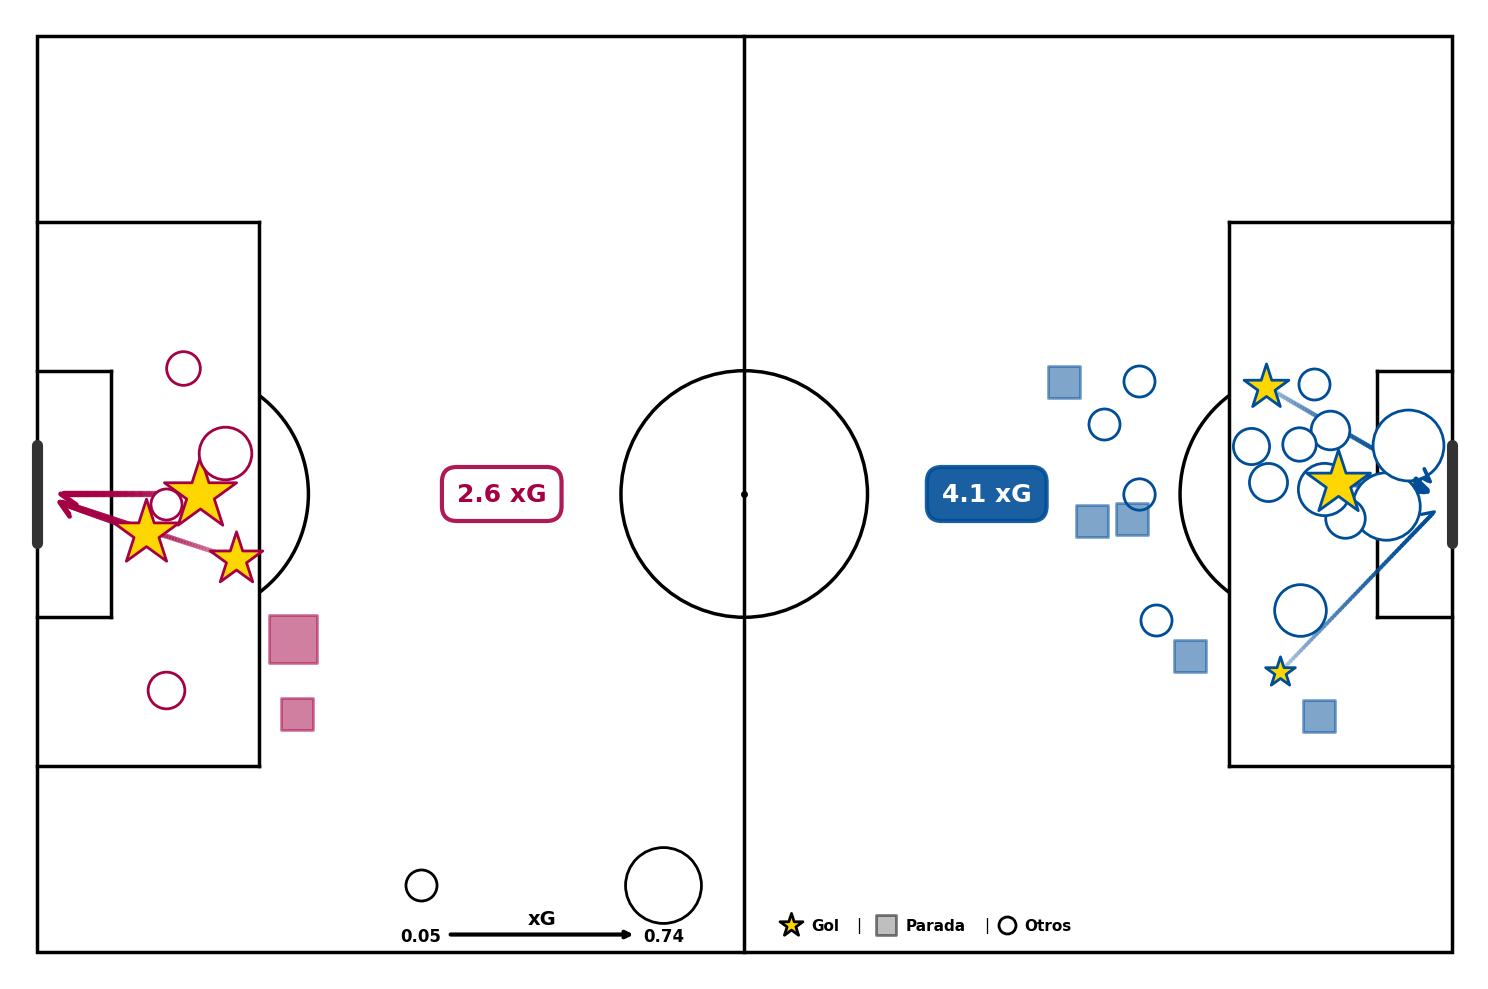

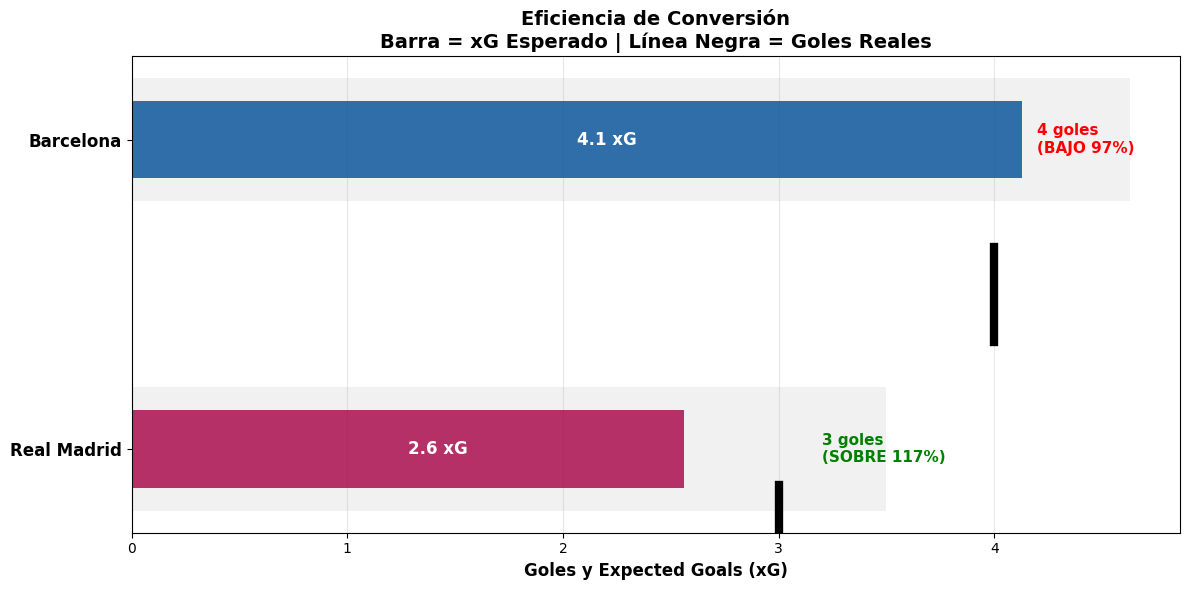

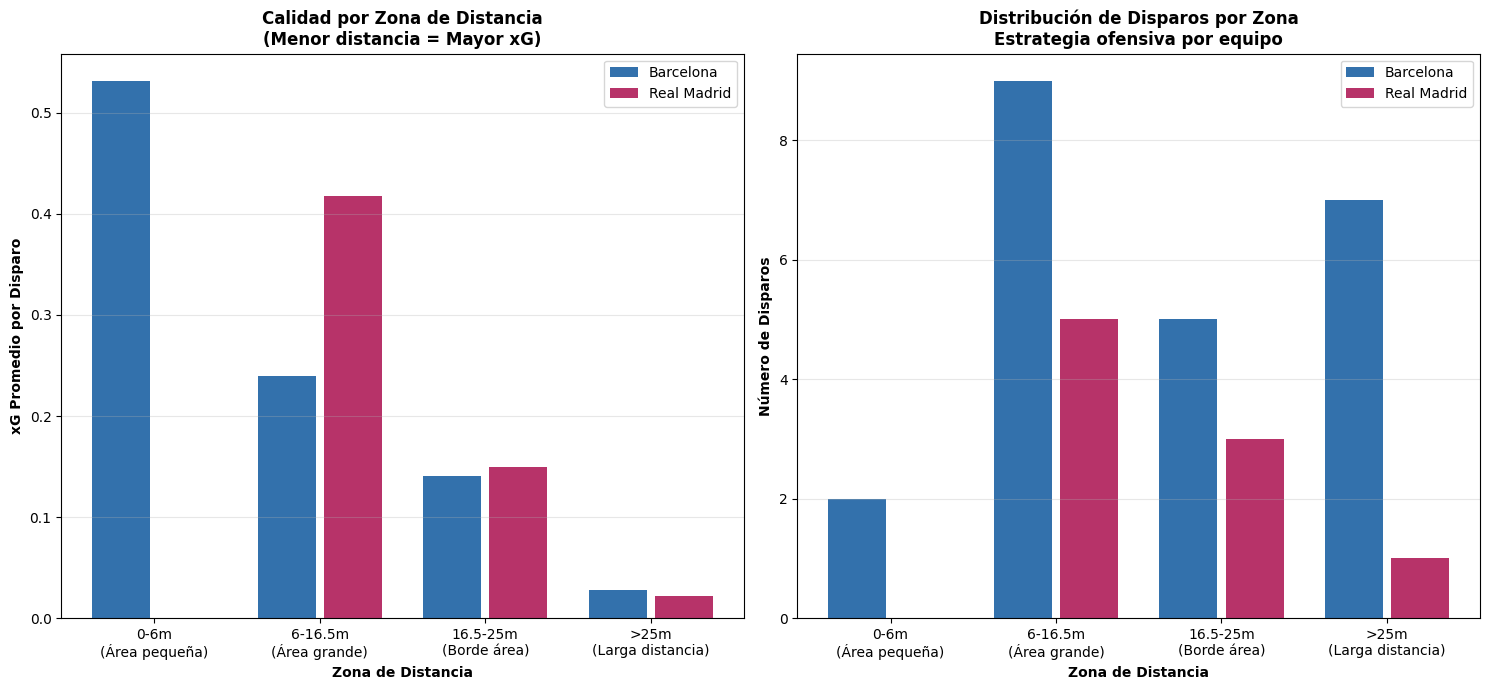

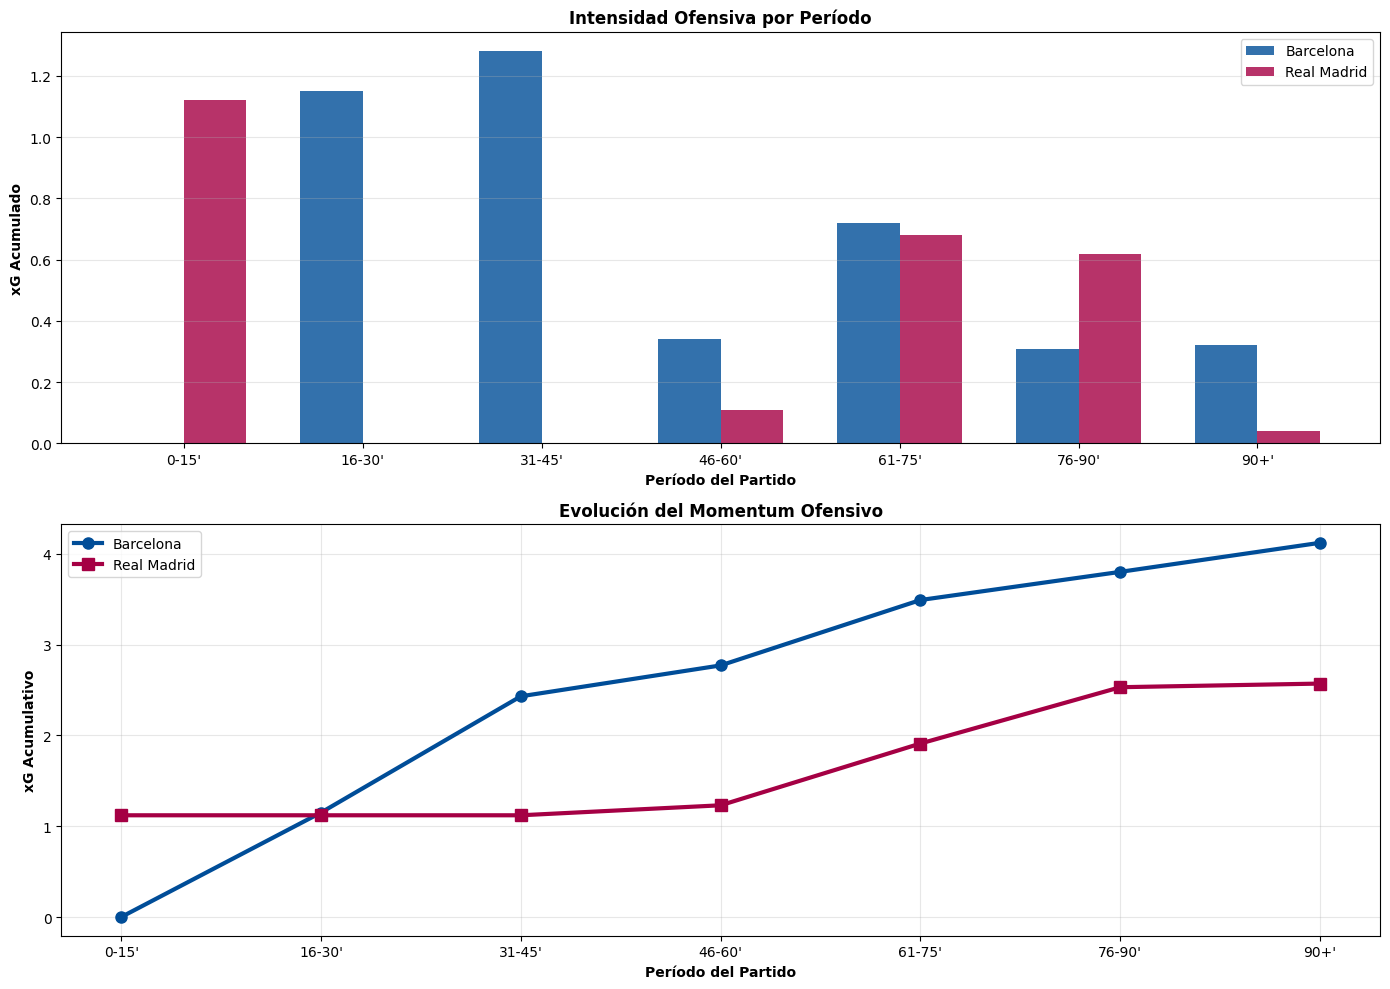

RESUMEN ESTADÍSTICO

EFICIENCIA DE CONVERSIÓN:
Real Madrid: 117% (+17% vs xG esperado)
Barcelona: 97% (-3% vs xG esperado)

RELACIÓN DISTANCIA-CALIDAD:
Disparos cercanos (≤16.5m): 0.332 xG promedio
Disparos lejanos (>16.5m): 0.086 xG promedio
Factor de mejora: 3.9x

ESTRATEGIAS OFENSIVAS:
Barcelona: 23 disparos, 0.180 xG promedio
Real Madrid: 9 disparos, 0.284 xG promedio
Diferencia calidad: +58%

PATRÓN ESTRATÉGICO:
Real Madrid desde área pequeña: 0 disparos
Concentración en zona de máxima eficiencia

Análisis completado: 32 disparos procesados


In [12]:
"""
Análisis Expected Goals (xG): Barcelona 4-3 Real Madrid
Análisis estadístico y visualizaciones de datos de disparos
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Rectangle
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from visualization.charts.shot_map import create_shot_map_with_match_data

def load_and_process_data():
    """Carga y procesa datos de disparos del partido"""
    df = pd.read_csv('data/match_understat_27324_shots.csv')
    
    df['team_name'] = df['team_id'].map({148: 'Barcelona', 150: 'Real Madrid'})
    team_colors = {'Barcelona': '#004D98', 'Real Madrid': '#A50044'}
    
    # Preparar datos para shot map
    df_shot_map = df.copy()
    df_shot_map['team'] = df_shot_map['team_name']
    df_shot_map['shot_result'] = df_shot_map['shot_result'].fillna('Missed Shot')
    
    match_data = {'shots': df_shot_map}
    
    return df, match_data, team_colors

def create_bullet_chart_academic(df):
    """
    Bullet Chart: Goles reales vs xG esperado
    Muestra eficiencia de conversión por equipo
    """
    
    team_metrics = df.groupby('team_name').agg({
        'shot_xg': 'sum',
        'is_goal': 'sum'
    }).round(2)
    
    team_metrics.columns = ['xG_Expected', 'Goals_Actual']
    team_metrics['Efficiency'] = (team_metrics['Goals_Actual'] / team_metrics['xG_Expected']).round(2)
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    colors = {'Barcelona': '#004D98', 'Real Madrid': '#A50044'}
    teams = team_metrics.index
    y_positions = [1, 0]
    
    for i, team in enumerate(teams):
        xg_expected = team_metrics.loc[team, 'xG_Expected']
        goals_actual = team_metrics.loc[team, 'Goals_Actual']
        efficiency = team_metrics.loc[team, 'Efficiency']
        
        # Barra de rango total
        max_val = max(xg_expected, goals_actual) + 0.5
        ax.barh(y_positions[i], max_val, height=0.4, 
                color='lightgray', alpha=0.3, zorder=1)
        
        # Barra de xG esperado
        ax.barh(y_positions[i], xg_expected, height=0.25, 
                color=colors[team], alpha=0.8, zorder=2)
        
        # Línea de goles reales
        ax.axvline(x=goals_actual, ymin=(y_positions[i]-0.2)/2, 
                  ymax=(y_positions[i]+0.2)/2, color='black', 
                  linewidth=6, zorder=3)
        
        # Etiquetas
        efficiency_text = "SOBRE" if efficiency > 1 else "BAJO"
        efficiency_color = "green" if efficiency > 1 else "red"
        
        ax.text(goals_actual + 0.2, y_positions[i], 
                f'{goals_actual} goles\n({efficiency_text} {efficiency:.0%})', 
                va='center', fontweight='bold', fontsize=11,
                color=efficiency_color)
        
        ax.text(xg_expected/2, y_positions[i], 
                f'{xg_expected:.1f} xG', va='center', 
                color='white', fontweight='bold', fontsize=12)
    
    ax.set_yticks(y_positions)
    ax.set_yticklabels(teams, fontsize=12, fontweight='bold')
    ax.set_xlabel('Goles y Expected Goals (xG)', fontsize=12, fontweight='bold')
    ax.set_title('Eficiencia de Conversión\nBarra = xG Esperado | Línea Negra = Goles Reales', 
                 fontweight='bold', fontsize=14)
    ax.grid(True, alpha=0.3, axis='x')
    ax.set_xlim(0, None)
    
    plt.tight_layout()
    return fig, team_metrics

def create_distance_validation_chart(df):
    """
    Análisis por zonas de distancia
    Valida relación distancia-calidad de disparos
    """
    
    def classify_distance_zone(distance):
        if distance <= 6: return "0-6m\n(Área pequeña)"
        elif distance <= 16.5: return "6-16.5m\n(Área grande)" 
        elif distance <= 25: return "16.5-25m\n(Borde área)"
        else: return ">25m\n(Larga distancia)"
    
    df['distance_zone'] = df['shot_distance_to_goal'].apply(classify_distance_zone)
    
    zone_analysis = df.groupby(['team_name', 'distance_zone']).agg({
        'shot_xg': ['count', 'sum', 'mean'],
        'is_goal': 'sum'
    }).round(3)
    
    zone_analysis.columns = ['Disparos', 'xG_Total', 'xG_Promedio', 'Goles']
    zone_analysis = zone_analysis.reset_index()
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
    
    colors = {'Barcelona': '#004D98', 'Real Madrid': '#A50044'}
    zone_order = ["0-6m\n(Área pequeña)", "6-16.5m\n(Área grande)", 
                  "16.5-25m\n(Borde área)", ">25m\n(Larga distancia)"]
    
    # xG Promedio por zona
    for team in df['team_name'].unique():
        team_data = zone_analysis[zone_analysis['team_name'] == team]
        
        zone_data = []
        for zone in zone_order:
            row = team_data[team_data['distance_zone'] == zone]
            zone_data.append(row['xG_Promedio'].iloc[0] if not row.empty else 0)
        
        x_positions = np.arange(len(zone_order))
        if team == 'Barcelona':
            x_positions = x_positions - 0.2
        else:
            x_positions = x_positions + 0.2
            
        ax1.bar(x_positions, zone_data, width=0.35, 
               color=colors[team], alpha=0.8, label=team)
    
    ax1.set_xlabel('Zona de Distancia', fontweight='bold')
    ax1.set_ylabel('xG Promedio por Disparo', fontweight='bold')
    ax1.set_title('Calidad por Zona de Distancia\n(Menor distancia = Mayor xG)', fontweight='bold')
    ax1.set_xticks(range(len(zone_order)))
    ax1.set_xticklabels(zone_order, fontsize=10)
    ax1.legend()
    ax1.grid(True, alpha=0.3, axis='y')
    
    # Volumen de disparos por zona
    for team in df['team_name'].unique():
        team_data = zone_analysis[zone_analysis['team_name'] == team]
        
        volume_data = []
        for zone in zone_order:
            row = team_data[team_data['distance_zone'] == zone]
            volume_data.append(row['Disparos'].iloc[0] if not row.empty else 0)
        
        x_positions = np.arange(len(zone_order))
        if team == 'Barcelona':
            x_positions = x_positions - 0.2
        else:
            x_positions = x_positions + 0.2
            
        ax2.bar(x_positions, volume_data, width=0.35, 
               color=colors[team], alpha=0.8, label=team)
    
    ax2.set_xlabel('Zona de Distancia', fontweight='bold')
    ax2.set_ylabel('Número de Disparos', fontweight='bold')
    ax2.set_title('Distribución de Disparos por Zona\nEstrategia ofensiva por equipo', fontweight='bold')
    ax2.set_xticks(range(len(zone_order)))
    ax2.set_xticklabels(zone_order, fontsize=10)
    ax2.legend()
    ax2.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    return fig, zone_analysis

def create_temporal_analysis(df):
    """
    Análisis temporal del partido
    Momentum ofensivo por períodos
    """
    
    bins = [0, 15, 30, 45, 60, 75, 90, 120]
    labels = ['0-15\'', '16-30\'', '31-45\'', '46-60\'', '61-75\'', '76-90\'', '90+\'']
    df['time_period'] = pd.cut(df['shot_minute'], bins=bins, labels=labels, include_lowest=True)
    
    temporal_data = df.groupby(['time_period', 'team_name']).agg({
        'shot_xg': ['count', 'sum'],
        'is_goal': 'sum'
    }).round(2)
    
    temporal_data.columns = ['Disparos', 'xG_Total', 'Goles']
    temporal_data = temporal_data.reset_index()
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))
    
    colors = {'Barcelona': '#004D98', 'Real Madrid': '#A50044'}
    
    # xG por período
    periods = labels
    barca_xg = []
    madrid_xg = []
    
    for period in periods:
        barca_data = temporal_data[(temporal_data['time_period'] == period) & 
                                 (temporal_data['team_name'] == 'Barcelona')]
        madrid_data = temporal_data[(temporal_data['time_period'] == period) & 
                                  (temporal_data['team_name'] == 'Real Madrid')]
        
        barca_xg.append(barca_data['xG_Total'].iloc[0] if not barca_data.empty else 0)
        madrid_xg.append(madrid_data['xG_Total'].iloc[0] if not madrid_data.empty else 0)
    
    x = np.arange(len(periods))
    width = 0.35
    
    ax1.bar(x - width/2, barca_xg, width, label='Barcelona', 
           color=colors['Barcelona'], alpha=0.8)
    ax1.bar(x + width/2, madrid_xg, width, label='Real Madrid', 
           color=colors['Real Madrid'], alpha=0.8)
    
    ax1.set_xlabel('Período del Partido', fontweight='bold')
    ax1.set_ylabel('xG Acumulado', fontweight='bold')
    ax1.set_title('Intensidad Ofensiva por Período', fontweight='bold')
    ax1.set_xticks(x)
    ax1.set_xticklabels(periods)
    ax1.legend()
    ax1.grid(True, alpha=0.3, axis='y')
    
    # xG acumulativo
    barca_cumsum = np.cumsum(barca_xg)
    madrid_cumsum = np.cumsum(madrid_xg)
    
    ax2.plot(periods, barca_cumsum, marker='o', linewidth=3, 
            color=colors['Barcelona'], label='Barcelona', markersize=8)
    ax2.plot(periods, madrid_cumsum, marker='s', linewidth=3, 
            color=colors['Real Madrid'], label='Real Madrid', markersize=8)
    
    ax2.set_xlabel('Período del Partido', fontweight='bold')
    ax2.set_ylabel('xG Acumulativo', fontweight='bold')
    ax2.set_title('Evolución del Momentum Ofensivo', fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig, temporal_data

def generate_statistical_summary(df, team_metrics, zone_analysis):
    """Genera resumen estadístico del análisis"""
    
    print("RESUMEN ESTADÍSTICO")
    print("=" * 50)
    
    # Eficiencia de conversión
    barca_eff = team_metrics.loc['Barcelona', 'Efficiency']
    madrid_eff = team_metrics.loc['Real Madrid', 'Efficiency']
    
    print(f"\nEFICIENCIA DE CONVERSIÓN:")
    print(f"Real Madrid: {madrid_eff:.0%} ({(madrid_eff-1)*100:+.0f}% vs xG esperado)")
    print(f"Barcelona: {barca_eff:.0%} ({(barca_eff-1)*100:+.0f}% vs xG esperado)")
    
    # Validación de relación distancia-xG
    close_shots = df[df['shot_distance_to_goal'] <= 16.5]
    far_shots = df[df['shot_distance_to_goal'] > 16.5]
    
    close_avg = close_shots['shot_xg'].mean()
    far_avg = far_shots['shot_xg'].mean()
    improvement_factor = close_avg / far_avg
    
    print(f"\nRELACIÓN DISTANCIA-CALIDAD:")
    print(f"Disparos cercanos (≤16.5m): {close_avg:.3f} xG promedio")
    print(f"Disparos lejanos (>16.5m): {far_avg:.3f} xG promedio")
    print(f"Factor de mejora: {improvement_factor:.1f}x")
    
    # Estrategias ofensivas
    barca_shots = len(df[df['team_name'] == 'Barcelona'])
    madrid_shots = len(df[df['team_name'] == 'Real Madrid'])
    
    barca_quality = team_metrics.loc['Barcelona', 'xG_Expected'] / barca_shots
    madrid_quality = team_metrics.loc['Real Madrid', 'xG_Expected'] / madrid_shots
    
    print(f"\nESTRATEGIAS OFENSIVAS:")
    print(f"Barcelona: {barca_shots} disparos, {barca_quality:.3f} xG promedio")
    print(f"Real Madrid: {madrid_shots} disparos, {madrid_quality:.3f} xG promedio")
    print(f"Diferencia calidad: {((madrid_quality/barca_quality-1)*100):+.0f}%")
    
    # Distribución por zonas
    madrid_area_pequena = len(df[(df['team_name'] == 'Real Madrid') & 
                                (df['shot_distance_to_goal'] <= 6)])
    print(f"\nPATRÓN ESTRATÉGICO:")
    print(f"Real Madrid desde área pequeña: {madrid_area_pequena} disparos")
    print(f"Concentración en zona de máxima eficiencia")

def main():
    """Ejecuta análisis completo de xG"""
    
    print("Análisis xG: Barcelona 4-3 Real Madrid")
    print("Match ID: 27324")
    
    # Cargar y procesar datos
    df, match_data, team_colors = load_and_process_data()
    
    # Generar visualizaciones
    print("\nGenerando visualizaciones...")
    
    # Shot map
    fig_shot_map = create_shot_map_with_match_data(match_data, team_colors)
    plt.show()
    
    # Bullet chart
    fig_bullet, team_metrics = create_bullet_chart_academic(df)
    plt.show()
    
    # Análisis por distancia
    fig_distance, zone_analysis = create_distance_validation_chart(df)
    plt.show()
    
    # Análisis temporal
    fig_temporal, temporal_data = create_temporal_analysis(df)
    plt.show()
    
    # Resumen estadístico
    generate_statistical_summary(df, team_metrics, zone_analysis)
    
    print(f"\nAnálisis completado: {len(df)} disparos procesados")
    
    return df, team_metrics, zone_analysis, temporal_data

if __name__ == "__main__":
    df, team_metrics, zone_analysis, temporal_data = main()

## Análisis del Clásico: Dos Filosofías Completamente Opuestas

Después de analizar los datos del Barcelona 4-3 Real Madrid, lo que más me ha llamado la atención es cómo este partido ejemplifica perfectamente dos filosofías ofensivas completamente diferentes. Es fascinante ver cómo los números confirman muchas de las teorías que hemos estado estudiando sobre xG y análisis espacial.

### La Historia que Cuentan los Números

Lo primero que salta a la vista es la **diferencia brutal en eficiencia**. Madrid logró una eficiencia del 117% (superó sus expectativas en un 17%), mientras que Barcelona se quedó en el 97% (-3% vs lo esperado). Esto es exactamente lo que StatsBomb menciona cuando habla de que "los jugadores tienden a sobreestimar sus habilidades individuales para rematar con un ángulo más que escaso". Barcelona disparó mucho, pero no siempre desde las mejores posiciones.

La diferencia en volumen es impresionante: **23 disparos del Barça contra solo 9 del Madrid**. Pero aquí viene lo interesante - Madrid tuvo un 58% más de calidad por disparo (0.284 xG promedio vs 0.180 del Barcelona). Esto me recuerda a la filosofía de equipos como el Liverpool que menciona la documentación: concentrarse en zonas de mayor probabilidad en lugar de disparar desde cualquier lado.

### Validación Empírica de la Teoría

Los datos confirman perfectamente la teoría de distancia-calidad que hemos estudiado. Los disparos cercanos (≤16.5m) tuvieron un xG promedio de 0.332, mientras que los lejanos solo 0.086. Eso es **3.9 veces más probabilidad de gol** en zona cercana. StatsBomb ya lo había documentado con el Liverpool: desde más de 27 metros el xG es de 0.026, pero entre 0-6 metros sube a 0.492 - prácticamente se marca 1 de cada 2.

### El Patrón Estratégico Más Llamativo

Lo que más me ha sorprendido es que **Real Madrid nunca disparó desde área pequeña** (0 disparos desde ≤6m). Esto va contra la lógica básica de "mientras más cerca, mejor", pero tiene sentido táctico. Madrid se concentró en el área grande donde tenía máxima eficiencia sin asumir el riesgo de perder balones en zona muy peligrosa. Barcelona, en cambio, tuvo 2 disparos desde área pequeña pero con una calidad individual brutal (0.532 xG promedio).

Esto me hace pensar en la teoría sobre "zonas no centradas en área son poco eficientes" que menciona StatsBomb. Madrid fue más selectivo, esperando mejores oportunidades en zona de área grande donde podía combinar buena probabilidad con menos presión defensiva.

### La Evolución Temporal del Partido

El análisis temporal revela momentos clave del partido. Madrid empezó muy fuerte (1.1 xG en los primeros 15 minutos), mientras Barcelona respondió masivamente entre el minuto 16-45 (2.4 xG acumulado). Esta diferencia de momentum explica por qué el partido tuvo tantos goles - ambos equipos tuvieron períodos de dominio claro donde generaron peligro real.

La línea acumulativa muestra cómo Barcelona mantuvo presión constante (llegó a 4.1 xG total), pero Madrid fue más "ráfaga" - períodos intensos seguidos de momentos más conservadores, acabando con 2.6 xG.

### Conexión con la Realidad Táctica

Si miramos el contexto del partido (según el análisis de Coaches Voice), este era un Clásico donde ambos equipos necesitaban ganar. Barcelona optó por presión alta y volumen de ocasiones - la típica filosofía del "si disparamos 23 veces, algo tiene que entrar". Madrid fue más pragmático: seleccionar mejor los momentos, buscar espacios en área grande, y ser letales cuando llegaran.

Los datos confirman que Madrid "superó" sus expectativas porque fueron más clínicos en los momentos clave. Barcelona estuvo "dentro" de lo esperado porque, aunque generó mucho, una parte importante fueron disparos de baja calidad desde zonas alejadas.

### Reflexión Final

Este partido es un caso de estudio perfecto sobre cómo dos filosofías pueden ser válidas. Barcelona dominó territorialmente y en volumen, pero Madrid fue más eficiente espacialmente. La teoría del xG se cumple: distancia importa, ángulo importa, y selección de disparo importa. Pero también vemos que en fútbol de élite, la "tranquilidad del rematador" que menciona StatsBomb puede ser la diferencia entre cumplir expectativas o superarlas.

Al final, Madrid ganó porque cuando tuvo sus ocasiones las aprovechó mejor, mientras que Barcelona, a pesar de generar 1.5 xG más, no pudo convertir esa superioridad numérica en goles suficientes.